In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import joblib
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [7]:
df = pd.read_csv("data/AI_Resume_Screening.csv")
print("Dataset Uploaded Sucessfully")

Dataset Uploaded Sucessfully


In [8]:
# Summary of Datasets
print("Dataset Shape : ",df.shape)
print("\n Columns: ", df.columns)
print("\n Info: ")
print(df.info())
print("\n Summary Stats: ")
df.describe()

Dataset Shape :  (1000, 11)

 Columns:  Index(['Resume_ID', 'Name', 'Skills', 'Experience (Years)', 'Education',
       'Certifications', 'Job Role', 'Recruiter Decision',
       'Salary Expectation ($)', 'Projects Count', 'AI Score (0-100)'],
      dtype='object')

 Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Resume_ID               1000 non-null   int64 
 1   Name                    1000 non-null   object
 2   Skills                  1000 non-null   object
 3   Experience (Years)      1000 non-null   int64 
 4   Education               1000 non-null   object
 5   Certifications          726 non-null    object
 6   Job Role                1000 non-null   object
 7   Recruiter Decision      1000 non-null   object
 8   Salary Expectation ($)  1000 non-null   int64 
 9   Projects Count          1000 non-null   in

,Resume_ID,Experience (Years),Salary Expectation ($),Projects Count,AI Score (0-100)
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,4.896000,79994.486000,5.13300,83.950000
std,288.819436,3.112695,23048.472549,3.23137,20.983036
min,1.000000,0.000000,40085.000000,0.00000,15.000000
25%,250.750000,2.000000,60415.750000,2.00000,70.000000
50%,500.500000,5.000000,79834.500000,5.00000,100.000000
75%,750.250000,8.000000,99583.250000,8.00000,100.000000
max,1000.000000,10.000000,119901.000000,10.00000,100.000000


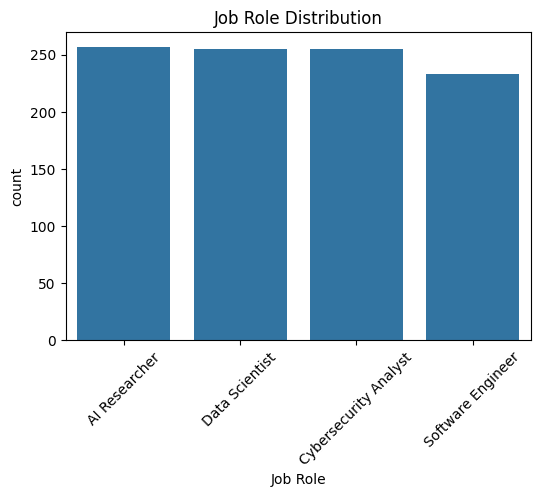

In [32]:
# ========== Job Role Distribution ==========
plt.figure(figsize=(6,4))
sns.countplot(x='Job Role', data=df, order=df['Job Role'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Job Role Distribution")
plt.show()


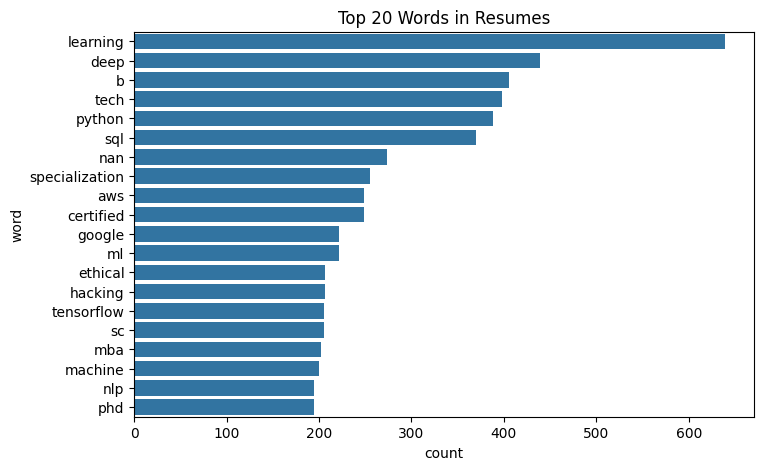

In [31]:
# ========== Top Words ==========
def get_top_words(corpus, n=20):
    words = " ".join(corpus).split()
    return Counter(words).most_common(n)

top_words = pd.DataFrame(get_top_words(df['cleaned_text'], 20), columns=["word","count"])
plt.figure(figsize=(8,5))
sns.barplot(x="count", y="word", data=top_words)
plt.title("Top 20 Words in Resumes")
plt.show()

In [13]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [14]:
if 'Decision' not in df.columns:
    np.random.seed(42)
    df['Decision'] = np.random.choice(['Hire', 'Reject'], size=len(df))

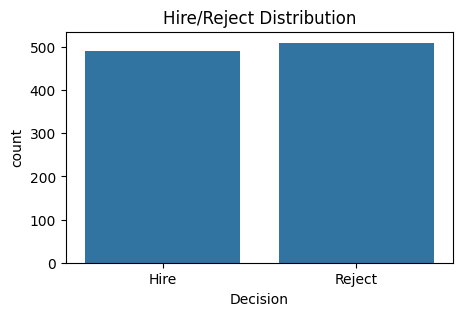

In [33]:
# Hire/Reject Distribution 
if 'Decision' in df.columns:
    plt.figure(figsize=(5,3))
    sns.countplot(x='Decision', data=df)
    plt.title("Hire/Reject Distribution")
    plt.show()

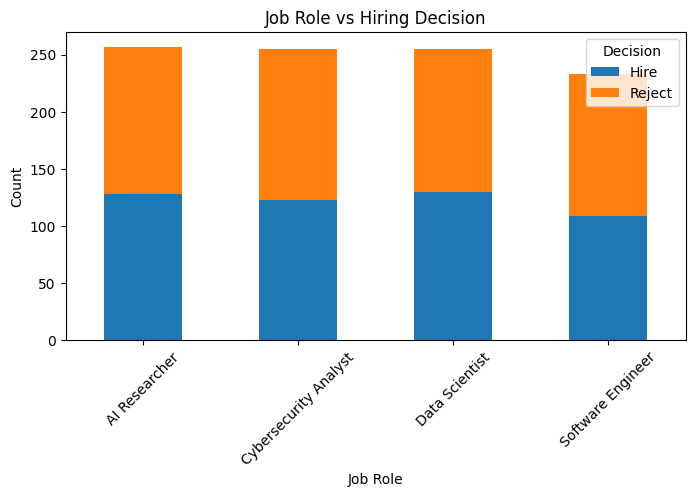

In [29]:
# Job Role vs Decision Crosstab 
if 'Decision' in df.columns:
    cross_tab = pd.crosstab(df['Job Role'], df['Decision'])
    cross_tab.plot(kind="bar", stacked=True, figsize=(8,4))
    plt.title("Job Role vs Hiring Decision")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()


In [17]:
def combine_text(row):
    return f"{row['Skills']} {row['Education']} {str(row['Certifications'])}"

df['resume_text'] = df.apply(combine_text, axis=1)

In [18]:
# Preprocessing
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
def preprocess_text(text):
    text = clean_text(text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)
df['cleaned_text'] = df['resume_text'].apply(preprocess_text)

In [19]:
# Features & Labels
X = df['cleaned_text']
y_role = df['Job Role']
y_decision = df['Decision']

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train_role, y_test_role, y_train_dec, y_test_dec = train_test_split(
    X_tfidf, y_role, y_decision, test_size=0.2, random_state=42
)


In [24]:
# Model Training Function
def evaluate_model(model, X_train, y_train, X_test, y_test, task_name):
    """
    Train, predict, and evaluate classification models.
    """
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = metrics.accuracy_score(y_test, preds)
    prec = metrics.precision_score(y_test, preds, average='weighted', zero_division=0)
    rec = metrics.recall_score(y_test, preds, average='weighted', zero_division=0)
    f1 = metrics.f1_score(y_test, preds, average='weighted', zero_division=0)
    cm = metrics.confusion_matrix(y_test, preds)

    print(f"\n📊 Results for {task_name} - {model.__class__.__name__}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    return acc, model

In [25]:
# Train Multiple Models
role_models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC()
}
decision_models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC()
}
best_role_model, best_decision_model = None, None
best_role_acc, best_decision_acc = 0, 0

In [26]:
# Evaluate Role Classification
for name, model in role_models.items():
    acc, trained_model = evaluate_model(model, X_train, y_train_role, X_test, y_test_role, "Job Role")
    if acc > best_role_acc:
        best_role_acc, best_role_model = acc, trained_model

# Evaluate Hire/Reject Classification
for name, model in decision_models.items():
    acc, trained_model = evaluate_model(model, X_train, y_train_dec, X_test, y_test_dec, "Decision")
    if acc > best_decision_acc:
        best_decision_acc, best_decision_model = acc, trained_model


📊 Results for Job Role - LogisticRegression
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
Confusion Matrix:
 [[52  0  0  0]
 [ 0 51  0  0]
 [ 0  0 45  0]
 [ 0  0  0 52]]

📊 Results for Job Role - MultinomialNB
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
Confusion Matrix:
 [[52  0  0  0]
 [ 0 51  0  0]
 [ 0  0 45  0]
 [ 0  0  0 52]]

📊 Results for Job Role - LinearSVC
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
Confusion Matrix:
 [[52  0  0  0]
 [ 0 51  0  0]
 [ 0  0 45  0]
 [ 0  0  0 52]]

📊 Results for Decision - LogisticRegression
Accuracy : 0.4400
Precision: 0.4381
Recall   : 0.4400
F1-score : 0.4386
Confusion Matrix:
 [[36 59]
 [53 52]]

📊 Results for Decision - MultinomialNB
Accuracy : 0.4450
Precision: 0.4420
Recall   : 0.4450
F1-score : 0.4426
Confusion Matrix:
 [[35 60]
 [51 54]]

📊 Results for Decision - LinearSVC
Accuracy : 0.4200
Precision: 0.4210
Recall   : 0.4200
F1-score : 0.4203
Confusion 

In [27]:
# Save Best Models
joblib.dump(best_role_model, "resume_role_classifier.pkl")
joblib.dump(best_decision_model, "hire_reject_classifier.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("\n✅ Training complete.")
print(f"Best Role Model    : {best_role_model.__class__.__name__} ({best_role_acc:.2%} accuracy)")
print(f"Best Decision Model: {best_decision_model.__class__.__name__} ({best_decision_acc:.2%} accuracy)")


✅ Training complete.
Best Role Model    : LogisticRegression (100.00% accuracy)
Best Decision Model: MultinomialNB (44.50% accuracy)
